# Node2Vec

In [1]:
import networkx as nx
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from node2vec import Node2Vec as n2v
from itertools import combinations, groupby
sns.set()

## Generate Data

## Create Graph

In [2]:
def generate_graph_deg_dist(deg_dist, dt = nx.MultiGraph()):
    '''
    This function will generate a networkx graph G based on a degree distribution
    provided by the user.
    
    params:
        deg_dist (List) : An list of degrees associated to the network you want to
                          create.
                          
    example:
        G = generate_graph_deg_dist(
            deg_dist = [7,5,2,5,6,7,5,3,2,1,4,5,7,4,3,2,5,7,8,10],
            dt = nx.MultiGraph()
        )
    '''
    G = dt
    G.add_nodes_from()
    pass

In [43]:
exp_deg = random.choice(x)

NameError: name 'x' is not defined

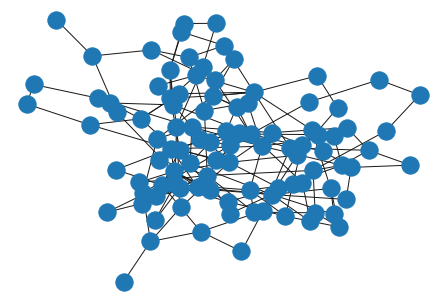

In [3]:
import numpy as np
p_k = [0, .01, .35, .25, .2, .1, .04, .01, .01, .02, .01]
k = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

expected_degree_sequence = np.random.choice(
  k, 
  100,
  p = p_k
)

G = nx.configuration_model(expected_degree_sequence)
nx.draw(G)
plt.show()

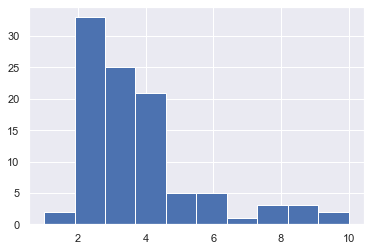

In [4]:
plt.hist(list(dict(G.degree()).values()))
plt.show()

In [5]:
from itertools import chain

In [26]:
chaini = chain.from_iterable

In [27]:
G = nx.MultiGraph()
deg_dist = [7,5,2,5,6,7,5,3,2,1,4,5,7,4,3,2,5,7,8,10]
n = len(deg_dist)
if n == 0:
    pass

In [28]:
stublist = list(chaini([n] * d for n, d in enumerate(deg_dist)))
# Choose a random balanced bipartition of the stublist, which
# gives a random pairing of nodes. In this implementation, we
# shuffle the list and then split it in half.
n = len(stublist)
half = n // 2
out_stublist, in_stublist = stublist[:half], stublist[half:]

In [29]:
G = nx.empty_graph(n)

In [30]:
G.add_edges_from(zip(out_stublist, in_stublist))

In [32]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 98
Number of edges: 18
Average degree:   0.3673


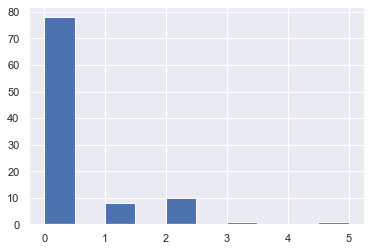

In [33]:
plt.hist(list(dict(G.degree()).values()))
plt.show()

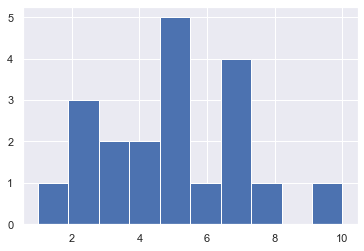

In [34]:
plt.hist(deg_dist)
plt.show()

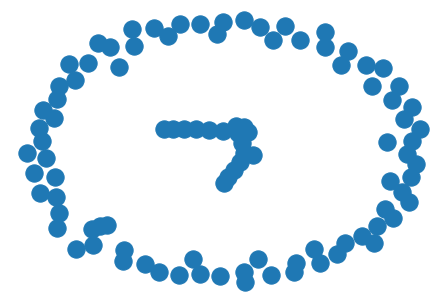

In [35]:
nx.draw(G)
plt.show()

In [2]:
def generate_graph(n, p, dt = nx.MultiGraph()):
    '''
    This function will generate a graph G based on the users input parameters
    source : https://stackoverflow.com/questions/61958360/how-to-create-random-graph-where-each-node-has-at-least-1-edge-using-networkx
    
    params:
        n (Integer) : The number of nodes you would like in the graph
        p (Float) : The probability of adding an edge between nodes
        dt (Function) : The type of the graph you want to create
    
    returns:
        A networkx graph
    
    example:
        G = generate_graph(
            n = 1000,
            p = 0.15,
            dt = nx.MultiGraph()
        )
    '''
    edges = combinations(range(n), 2)
    G = dt
    G.add_nodes_from(range(n))
    
    if p <= 0:
        return G
    elif p >= 1:
        return nx.complete_graph(n, create_using = G)
    else:
        for _, ne in groupby(edges, key = lambda x : x[0]):
            ne = list(ne)
            re = random.choice(ne)
            G.add_edge(*re)
            for e in ne:
                if random.random() < p:
                    G.add_edge(*e)
    return G

In [3]:
G = generate_graph(n = 1000, p = 0.15, dt = nx.MultiGraph())

In [4]:
print(nx.info(G))

Name: 
Type: MultiGraph
Number of nodes: 1000
Number of edges: 76106
Average degree: 152.2120


## Node2Vec

**Parameter Info**  
- graph: a graph g, where all nodes must be integers or strings  
- dimensions: embedding dimensions (default: 128)  
- walk_length: number of nodes in each walk (default: 80)  
- num_walks: number of walks per node (default: 10)  
- weight_key: the key for the weight attribute on weighted graphs (default: 'weight')  
- workers: number of workers for parallel execution (default: 1)

Node2Vec.fit method: Accepts any key word argument acceptable by gensim.Word2Vec

In [5]:
%time g_emb = n2v(G, dimensions=16)

Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:27<00:00,  2.70s/it]

CPU times: user 1min 21s, sys: 1.48 s, total: 1min 23s
Wall time: 1min 25s


In [6]:
WINDOW = 1 # Node2Vec fit window
MIN_COUNT = 1 # Node2Vec min. count
BATCH_WORDS = 4 # Node2Vec batch words

In [7]:
mdl = g_emb.fit(
    window=WINDOW,
    min_count=MIN_COUNT,
    batch_words=BATCH_WORDS
)

## Convert to DataFrame

In [8]:
emb_df = (
    pd.DataFrame(
        [mdl.wv.get_vector(str(n)) for n in G.nodes()],
        index = G.nodes
    )
)

In [9]:
emb_df.iloc[:,1:]

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.042499,0.599202,0.131481,0.278286,0.831986,0.281949,-0.273642,-0.808042,0.180614,-0.052981,-0.540917,-0.483045,-0.294049,0.701727,0.178055
1,-0.330986,-0.231267,0.003587,1.168752,0.579002,-0.161999,-0.330725,0.091164,-0.486864,0.003569,-0.593699,-0.040593,-0.688002,-0.313375,0.431983
2,0.304230,0.334667,-0.092769,0.350108,-0.265364,0.270009,0.257968,-0.552038,0.280843,-0.211313,-0.730613,-0.249435,-0.886305,0.759829,0.645053
3,0.734385,-0.165109,0.246572,0.453052,-0.180929,-0.194938,-0.718543,-0.194779,0.597054,0.542186,0.611232,0.272759,-0.865591,0.115880,0.933550
4,-0.234063,-0.048243,0.055356,0.553215,-0.111853,-0.445061,-0.323672,-0.052626,0.487470,0.292811,-0.746215,0.299139,0.087726,0.517616,0.590164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.251823,-0.257457,0.027162,0.557026,-0.023498,-0.058973,-0.581227,0.107935,1.163244,-0.072754,0.040069,0.488356,-0.507636,0.312345,0.704165
996,-0.128828,0.482044,0.742787,0.688232,-0.234364,-0.304009,-0.424569,-0.541949,-0.282350,-0.151753,0.083502,-0.676938,-0.616176,-0.037008,0.180500
997,-0.218733,0.228868,-0.003579,1.120260,0.375957,-0.454130,-0.498063,-0.500977,0.992491,-0.509789,-0.256933,-0.013000,-0.730055,-0.260329,-0.221898
998,-0.324546,0.132481,0.407514,0.553348,-0.068111,-0.292767,0.274578,-0.873066,0.381144,-0.684878,0.076659,-0.056257,-0.516235,-0.547458,0.596836


### Visualize Embedding

<Figure size 432x288 with 0 Axes>

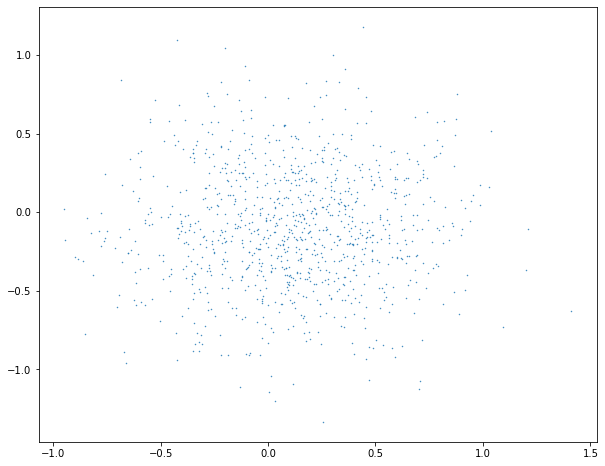

In [10]:
plt.clf()
fig=plt.figure(figsize=(10,8))
plt.scatter(
    x = emb_df.iloc[:,0],
    y = emb_df.iloc[:,1],
    s = 0.2
)
plt.show()


### PCA

In [11]:
pca = PCA(n_components = 2, random_state = 7)
pca_mdl = pca.fit_transform(emb_df)

[]

<Figure size 432x288 with 0 Axes>

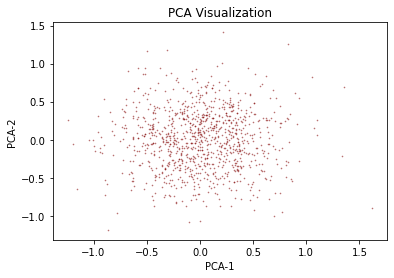

In [12]:
emb_df_PCA = (
    pd.DataFrame(
        pca_mdl,
        columns=['x','y'],
        index = emb_df.index
    )
)
plt.clf()
fig = plt.figure(figsize=(6,4))
plt.scatter(
    x = emb_df_PCA['x'],
    y = emb_df_PCA['y'],
    s = 0.4,
    color = 'maroon',
    alpha = 0.5
)
plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
plt.title('PCA Visualization')
plt.plot()

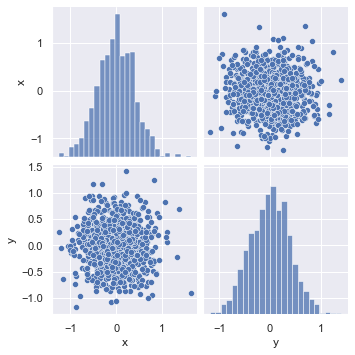

In [19]:
sns.pairplot(emb_df_PCA)

---